<h1> <strong> <center> Deep Learning Project -- Two-Stage Pipeline: UNet++ --> SEResNet50 </center> </strong> </h1>

<h4> <strong>  1)  Library Imports </strong> </h4>

In [39]:
# PyTorch Core and Utilities
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Torchvision and Image Preprocessing
import torchvision.transforms as transforms
from PIL import Image
import cv2

# Model Architectures
import timm  

# Data Handling and File Utilities
from pathlib import Path
import os
import random
from collections import Counter

# Numerical and Array Processing
import numpy as np

# Data Splitting and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Display
from tqdm import tqdm

# Grad-CAM for Explainability
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

<h4> <strong>  2)  Dice Loss Function: </strong> </h4>

- defines a custom Dice loss to measure overlap between predicted and ground truth masks for segmentation tasks.

In [40]:
class DiceLoss(nn.Module):
    def __init__(self, s=1e-6):
        super(DiceLoss, self).__init__()
        self.s = s

    def forward(self, p, t):
        p = p.contiguous().view(-1)
        t = t.contiguous().view(-1)
        dice_score = 1 - (((2. * ((p * t).sum())) + self.s) / ((p.pow(2).sum()) + (t.pow(2).sum()) + self.s))
        return dice_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install segmentation_models_pytorch

<h4> <strong>  3)  Loading Trained UNet++ Model: </strong> </h4>

- initializes a UNet++ model with a ResNet-101 encoder
- loads pretrained weights and sets it to evaluation mode.

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import segmentation_models_pytorch as smp
unet_model = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation=None,
    decoder_dropout=0.3
).to(device)

model_path = '/content/drive/MyDrive/UNet.pth'
unet_model.load_state_dict(torch.load(model_path, map_location=device))
unet_model.eval()
print("UNet++ model loaded.")


UNet++ model loaded.


<h4> <strong>  4)  Segmenting Images Using UNet++: </strong> </h4>

- loads images from multiple datasets, preprocesses and segments them using the pretrained UNet++ model
- stores masked outputs and labels for later classification

Processing Dataset 2 - TB...


100%|██████████| 700/700 [00:23<00:00, 29.51it/s]


Processing Dataset 3 - TB...


100%|██████████| 800/800 [00:33<00:00, 24.15it/s]


Processing Dataset 4 - TB...


100%|██████████| 700/700 [00:25<00:00, 27.69it/s]


Processing Dataset 3 - Normal...


100%|██████████| 3800/3800 [02:38<00:00, 23.96it/s]



✅ Total segmented images: 6000
   🔹 TB: 2200
   🔹 Normal: 3800


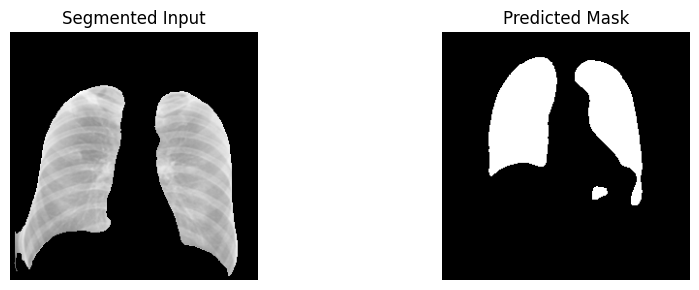

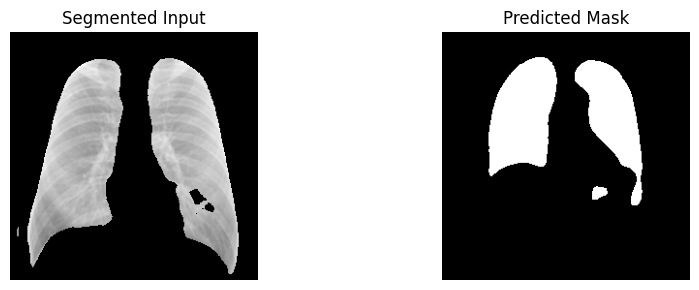

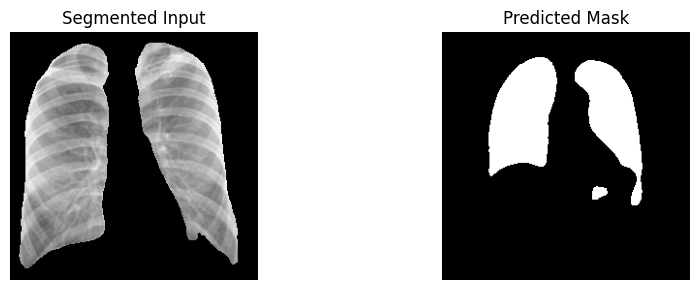

In [42]:
sources = {
    "Dataset 2 - TB":      (Path("/content/drive/MyDrive/Dataset2/Tuberculosis"), 1),
    "Dataset 3 - TB":      (Path("/content/drive/MyDrive/Dataset3/imgs/tb"), 1),
    "Dataset 4 - TB":      (Path("/content/drive/MyDrive/Dataset4/TURBERCULOSIS"), 1),
    # "Dataset 2 - Normal":  (Path("/content/drive/MyDrive/Dataset2/Normal"), 0),
    "Dataset 3 - Normal":  (Path("/content/drive/MyDrive/Dataset3/imgs/health"), 0),
    # "Dataset 4 - Normal":  (Path("/content/drive/MyDrive/Dataset4/NORMAL"), 0),
}

resize_transform = transforms.Resize((256, 256))

segmented_images = []
labels = []

for label_name, (path, label) in sources.items():
    print(f"Processing {label_name}...")
    for img_file in tqdm(list(path.glob("*"))):
        if img_file.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue

        try:
            image = Image.open(img_file).convert("L")
            image = resize_transform(image)
            image_np = np.array(image).astype(np.float32) / 255.0

            input_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0).to(device) 

            with torch.no_grad():
                mask_pred = unet_model(input_tensor)
                mask_pred = torch.sigmoid(mask_pred)
                mask_pred = (mask_pred > 0.5).float()

            segmented = input_tensor.squeeze(0) * mask_pred.squeeze(0) 
            segmented_images.append(segmented.cpu())
            labels.append(label)

        except Exception as e:
            print(f"Skipping file {img_file.name} due to error: {e}")

label_counts = Counter(labels)
print(f"\n Total segmented images: {len(labels)}")
print(f" TB: {label_counts.get(1, 0)}")
print(f" Normal: {label_counts.get(0, 0)}")

num_to_show = 5
for i in range(num_to_show):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(segmented_images[i][0], cmap='gray')
    plt.title("Segmented Input")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_pred[0, 0].cpu(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

<h4> <strong>  5)  Segmented Lung Dataset Class: </strong> </h4>

- creates a dataset from segmented lung images, resizing and converting them to 3-channel format for classification models

In [43]:
class SegmentedLungDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = transforms.Resize((224, 224))(image)  
        image = image.repeat(3, 1, 1) 

        return image, torch.tensor(self.labels[idx], dtype=torch.long)

<h4> <strong>  6)  Split and Load Segmented Data: </strong> </h4>

- shuffles and splits the segmented dataset into train, validation, and test sets, then loads them into PyTorch DataLoaders

In [44]:
combined = list(zip(segmented_images, labels))
random.shuffle(combined)
images, labels = zip(*combined)

train, temp = train_test_split(list(zip(images, labels)), test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

train_loader = DataLoader(SegmentedLungDataset(*zip(*train)), batch_size=8, shuffle=True)
val_loader = DataLoader(SegmentedLungDataset(*zip(*val)), batch_size=8)
test_loader = DataLoader(SegmentedLungDataset(*zip(*test)), batch_size=8)

In [45]:
def print_split_stats(name, dataset):
    _, labels = zip(*dataset)
    label_counts = Counter(labels)
    tb_count = label_counts.get(1, 0)
    normal_count = label_counts.get(0, 0)
    print(f"{name} set: {len(labels)} images → TB: {tb_count}, Normal: {normal_count}")

print_split_stats("Train", train)
print_split_stats("Validation", val)
print_split_stats("Test", test)

Train set: 4200 images → TB: 1520, Normal: 2680
Validation set: 900 images → TB: 340, Normal: 560
Test set: 900 images → TB: 340, Normal: 560


<h4> <strong>  7)  SEResNet50 Binary Classifier: </strong> </h4>

- defines a binary classifier using a pretrained SEResNet50 model 
- sets up the loss and optimizer

In [46]:
class SEResNet50Binary(nn.Module):
    def __init__(self):
        super(SEResNet50Binary, self).__init__()
        self.base = timm.create_model('seresnet50', pretrained=True)
        self.base.fc = nn.Linear(self.base.fc.in_features, 2)

    def forward(self, x):
        return self.base(x)

model = SEResNet50Binary().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

<h4> <strong>  8)  Train  Model: </strong> </h4>

- trains the SEResNet50 classifier over multiple epochs 

In [47]:
def train_model(model, train_loader, val_loader, epochs=5):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    return train_losses, val_losses

100%|██████████| 525/525 [00:55<00:00,  9.49it/s]


Epoch 1: Train Loss = 0.2647, Val Loss = 0.1421


100%|██████████| 525/525 [00:56<00:00,  9.33it/s]


Epoch 2: Train Loss = 0.1139, Val Loss = 0.1217


100%|██████████| 525/525 [00:56<00:00,  9.23it/s]


Epoch 3: Train Loss = 0.0742, Val Loss = 0.2308


100%|██████████| 525/525 [00:57<00:00,  9.16it/s]


Epoch 4: Train Loss = 0.0482, Val Loss = 0.0862


100%|██████████| 525/525 [00:57<00:00,  9.18it/s]


Epoch 5: Train Loss = 0.0291, Val Loss = 0.0783


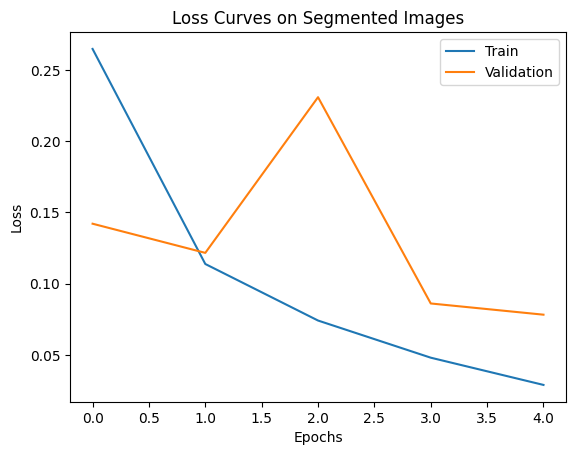

In [48]:
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=5)

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Loss Curves on Segmented Images")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

<h4> <strong>  9)  Evaluation on Test Set: </strong> </h4>

- generates predictions on the test set
- prints a classification report
- visualizes performance with a confusion matrix


📋 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       560
          TB       0.96      0.99      0.98       340

    accuracy                           0.98       900
   macro avg       0.98      0.99      0.98       900
weighted avg       0.98      0.98      0.98       900



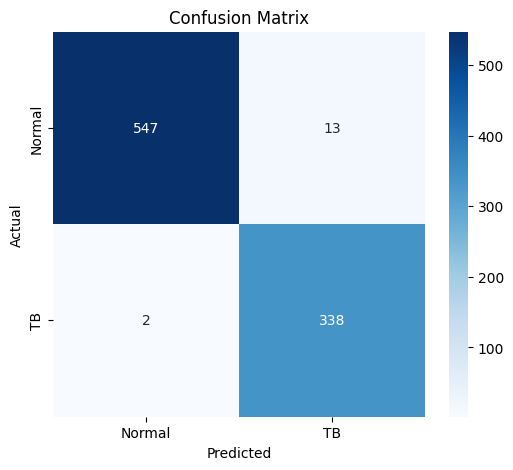

In [49]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "TB"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<h4> <strong>  10)  Dice and IoU evaluation: </strong> </h4>

- computes Dice Coefficient and IoU specifically for TB class to evaluate segmentation overlap and prediction accuracy

In [50]:
def dice_coef_class_1(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)

    intersection = np.sum(y_true_bin * y_pred_bin)
    total = np.sum(y_true_bin) + np.sum(y_pred_bin)
    dice = (2 * intersection) / total if total > 0 else 1.0
    return dice

def iou_score_class_1(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)

    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin) - intersection
    iou = intersection / union if union > 0 else 1.0
    return iou

dice_score_tb = dice_coef_class_1(y_true, y_pred)
iou_score_tb = iou_score_class_1(y_true, y_pred)

print(f"\n Dice Coefficient (TB Class): {dice_score_tb:.4f}")
print(f" IoU Score (TB Class): {iou_score_tb:.4f}")


🧪 Dice Coefficient (TB Class): 0.9783
📏 IoU Score (TB Class): 0.9575


<h4> <strong>  11)  Grad-CAM++ Visualization on Test Samples: </strong> </h4>

- uses Grad-CAM++ to highlight important regions influencing SEResNet50's predictions
- visualizes segmented inputs alongside attention heatmaps for interpretability

In [ ]:
!pip install grad-cam

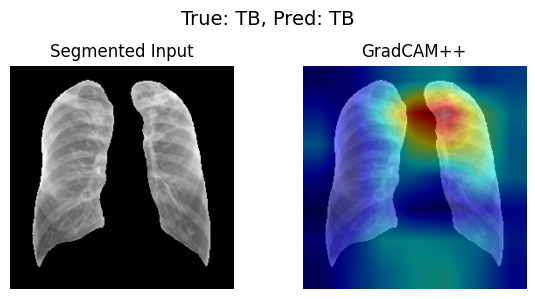

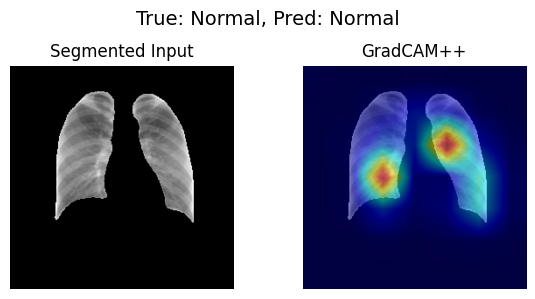

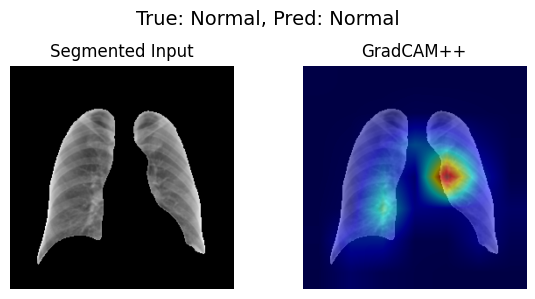

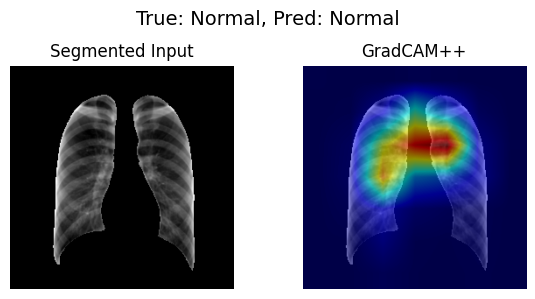

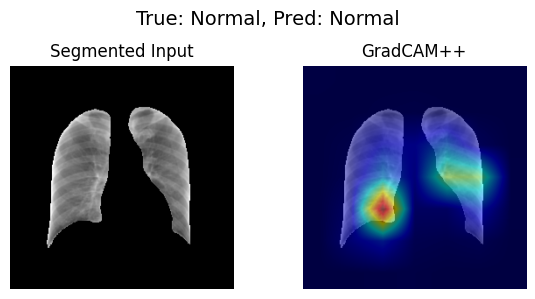

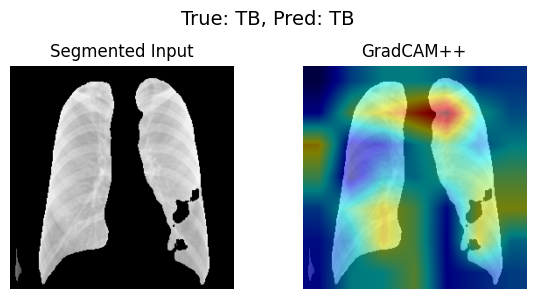

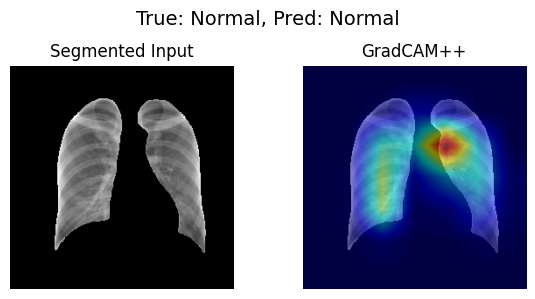

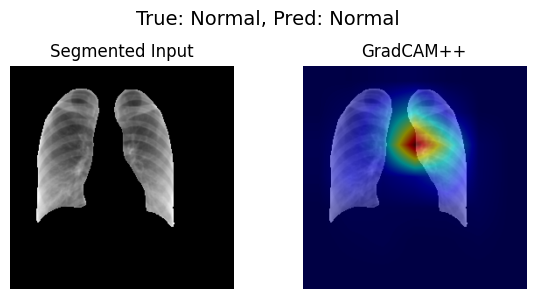

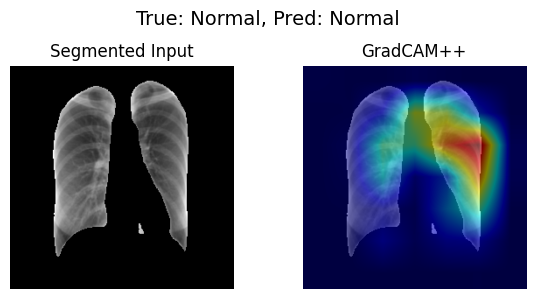

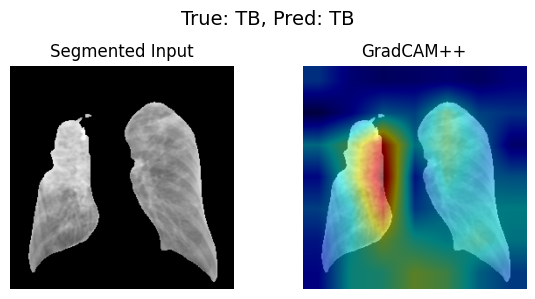

In [55]:
target_layers = [model.base.layer4[-1]]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

class SegmentedLungDatasetVisual(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = transforms.Resize((224, 224))(self.images[idx]) 
        image = image.repeat(3, 1, 1)  
        return image, self.labels[idx]


def visualize_gradcam(dataset, num_images=5):
    model.eval()
    shown = 0

    for i in range(len(dataset)):
        img_tensor, label = dataset[i]
        input_tensor = img_tensor.unsqueeze(0).to(device) 

        rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy() 
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

        with torch.no_grad():
            outputs = model(input_tensor)
        pred_class = outputs.argmax().item()

        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
        grayscale_cam = grayscale_cam[0]  
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(6, 3))
        plt.suptitle(f"True: {'TB' if label==1 else 'Normal'}, Pred: {'TB' if pred_class==1 else 'Normal'}", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.title("Segmented Input")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cam_image)
        plt.title("GradCAM++")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= num_images:
            break

visual_dataset = SegmentedLungDatasetVisual(*zip(*test)) 
visualize_gradcam(visual_dataset, num_images=10)

<h4> <strong>  12)  Save Model: </strong> </h4>

In [56]:
torch.save(model.state_dict(), "SEResNet50_segmented.pth")
print("Model saved")

Model saved
